# Simple PE Example

Code to generate the metric and parameter accuracies for an unequal mass BBH merger

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict
from pesummary.gw.conversions import convert

In [2]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

In [3]:
savefig = True

## Read in PSDs, etc

In [4]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

approximant = 'IMRPhenomXPHM'

In [5]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


## Parameters

GW190412-like signal

In [6]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
snr = 18

In [7]:
params = {'mass_1': m1,
          'mass_2': m2,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

## Spin directions

In [8]:
dx_directions = ['spin_1z', 'spin_2z']

In [9]:
g_spin = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [10]:
print(g_spin.dx_directions)
print(g_spin.metric)
print(g_spin.evec)
print(g_spin.evals)

['spin_1z', 'spin_2z']
[[39.23813108  9.02431929]
 [ 9.02431929  2.07771929]]
[[ 0.97455786 -0.22413607]
 [ 0.22413607  0.97455786]]
[4.13137417e+01 2.11884800e-03]


In [11]:
spin_ellipse = g_spin.generate_ellipse()

In [12]:
spin_mat = g_spin.generate_match_grid(npts=21, mismatch=g_spin.mismatch*(1.3)**2)
spin_p = np.exp(-snr**2/2 * (1 - spin_mat['match']))

In [13]:
chi1, chi2 = np.mgrid[0:0.6:21j, -1:1:21j]
q = m2/m1
chieff = (chi1 + q * chi2)/(1+q)

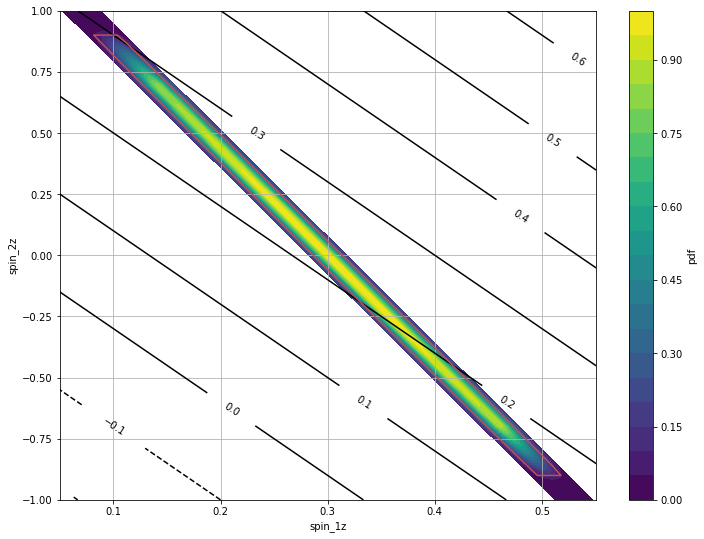

In [14]:
plt.figure(figsize=(12, 9))
plt.contourf(spin_mat.samples[0], spin_mat.samples[1], spin_p, levels=np.linspace(0, 1, 21))
plt.xlabel(spin_mat.keys()[0])
plt.ylabel(spin_mat.keys()[1])
plt.colorbar(label='pdf')
plt.plot(spin_ellipse.samples[0], spin_ellipse.samples[1], 'r')
chi_cont = plt.contour(chi1, chi2, chieff, colors='k', levels=np.arange(-1,1,0.1))
plt.clabel(chi_cont, fontsize=10)
plt.xlim([0.05, 0.55])
plt.ylim([-1,1])
plt.grid()
plt.savefig('spin_measurement.png')

## Masses

In [15]:
dx_directions = ['mass_1', 'mass_2']

In [16]:
g_mass = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [17]:
mass_ellipse = g_mass.generate_ellipse()

In [18]:
mass_matches = g_mass.generate_match_grid(npts=21, mismatch=g_mass.mismatch*(1.3)**2)
mass_prob = np.exp(-snr**2/2 * (1 - mass_matches['match']))

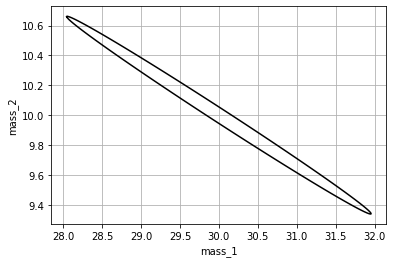

In [19]:
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'k')
plt.xlabel(mass_ellipse.keys()[0])
plt.ylabel(mass_ellipse.keys()[1])
plt.grid()

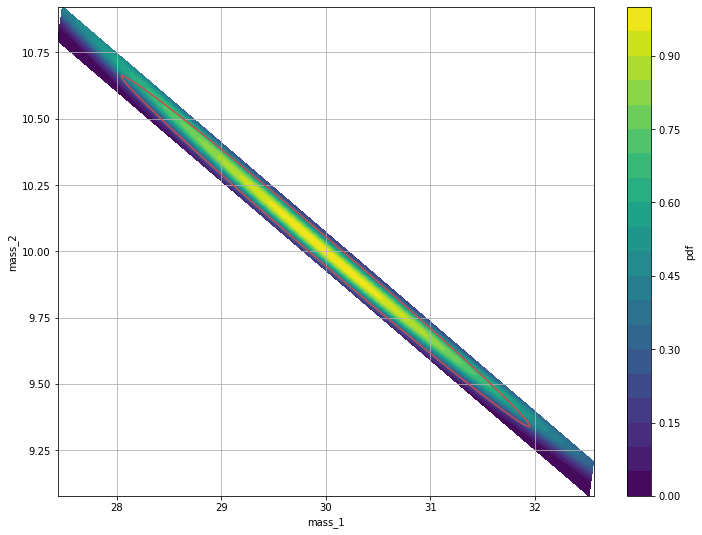

In [20]:
plt.figure(figsize=(12, 9))
plt.contourf(mass_matches.samples[0], mass_matches.samples[1], mass_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mass_matches.keys()[0])
plt.ylabel(mass_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'r')
plt.grid()

### Repeat with chirp mass and eta

In [21]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

In [22]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio']

In [23]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [24]:
mceta_ellipse = g_mceta.generate_ellipse()

In [25]:
mceta_matches = g_mceta.generate_match_grid(npts=21, mismatch=g_mceta.mismatch*(1.3)**2)
mceta_prob = np.exp(-snr**2/2 * (1 - mceta_matches['match']))

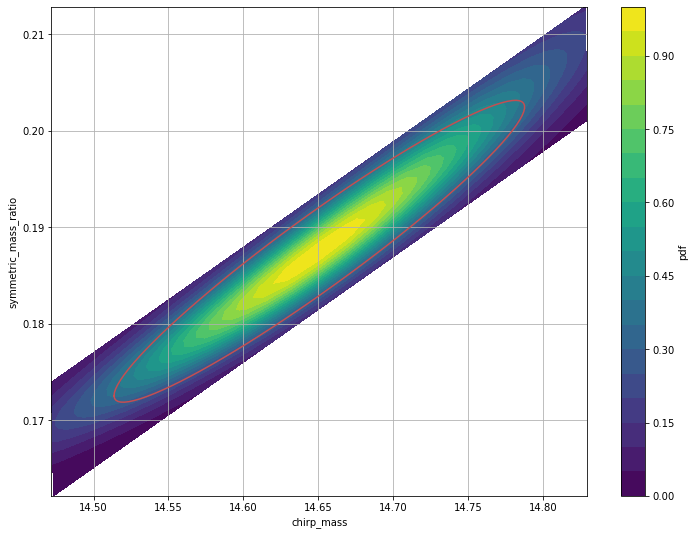

In [26]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_matches.samples[0], mceta_matches.samples[1], mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_matches.keys()[0])
plt.ylabel(mceta_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()

In [27]:
mass1 = conversions.mass1_from_mchirp_eta(mceta_matches['chirp_mass'], mceta_matches['symmetric_mass_ratio'])
mass2 = conversions.mass2_from_mchirp_eta(mceta_matches['chirp_mass'], mceta_matches['symmetric_mass_ratio'])

mass1_el = conversions.mass1_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])
mass2_el = conversions.mass2_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])

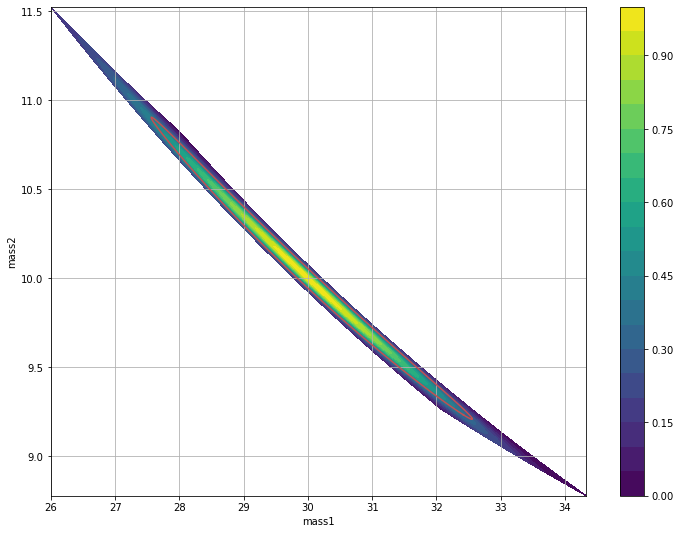

In [28]:
plt.figure(figsize=(12, 9))
plt.contourf(mass1, mass2, mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.plot(mass1_el, mass2_el, 'r')
plt.colorbar()
plt.grid()

## Three dimensions with projection

Note: we are using "chi_eff", but that's just putting the same spin on both BHs, so probably don't need to worry about the fact that it's not the best measured spin direction.

In [29]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff
        }

In [30]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']

In [31]:
g_3d = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

## Two dimensional projections

In [32]:
keep_dirs = {'mc_eta':['chirp_mass','symmetric_mass_ratio'],
            'chip_chieff': ['symmetric_mass_ratio', 'chi_eff'],
            'mc_chieff':['chirp_mass', 'chi_eff']}

In [33]:
g_2d = {}

In [34]:
npts = 21

In [35]:
for key, dx_keep in keep_dirs.items():
    g_2d[key] = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

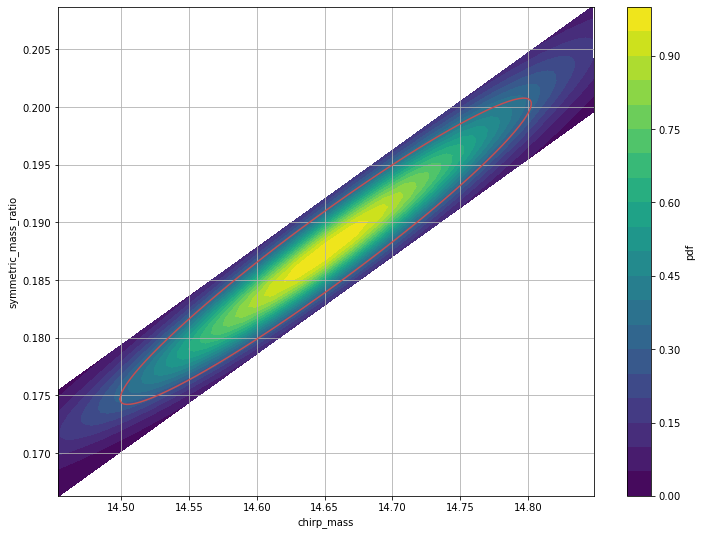

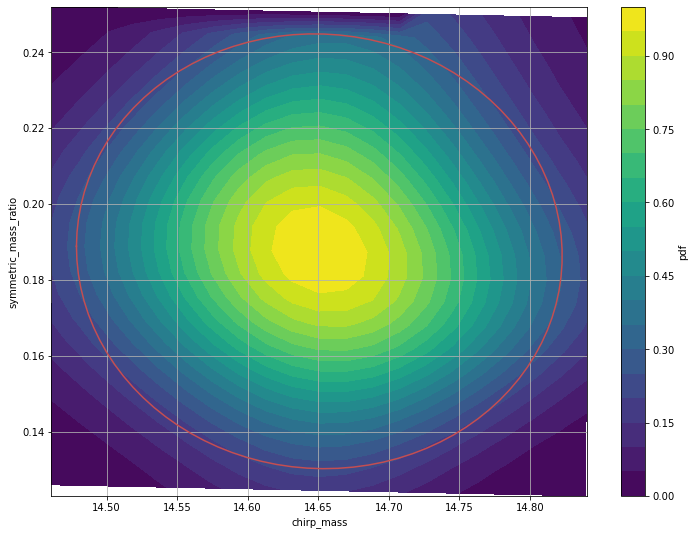

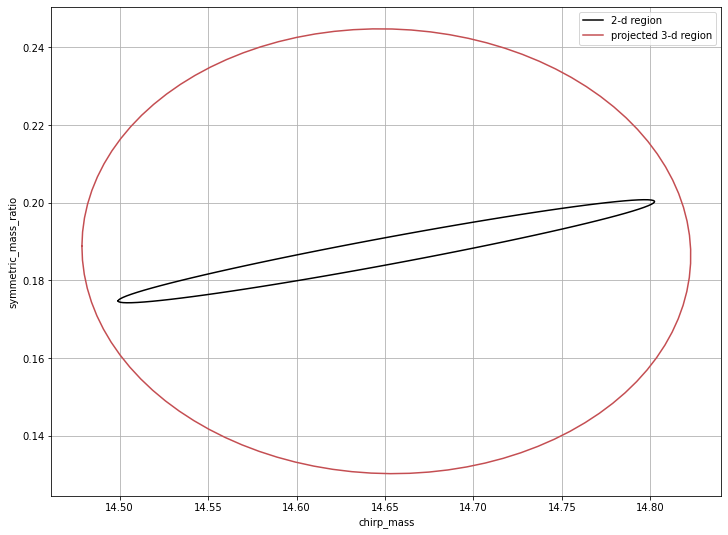

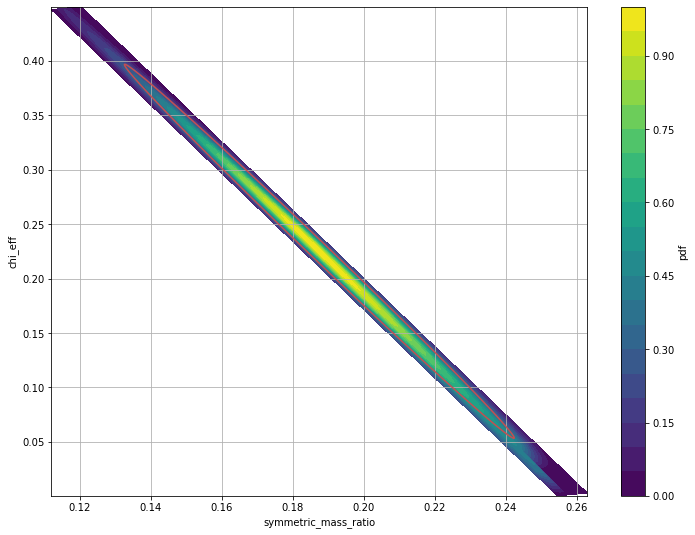

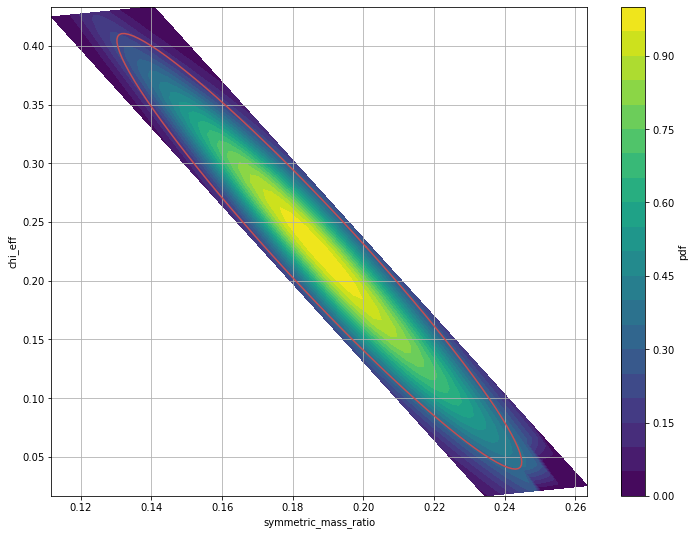

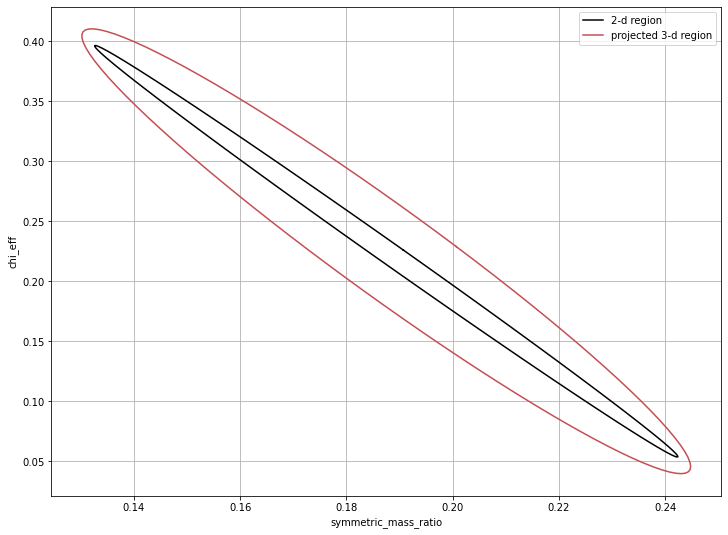

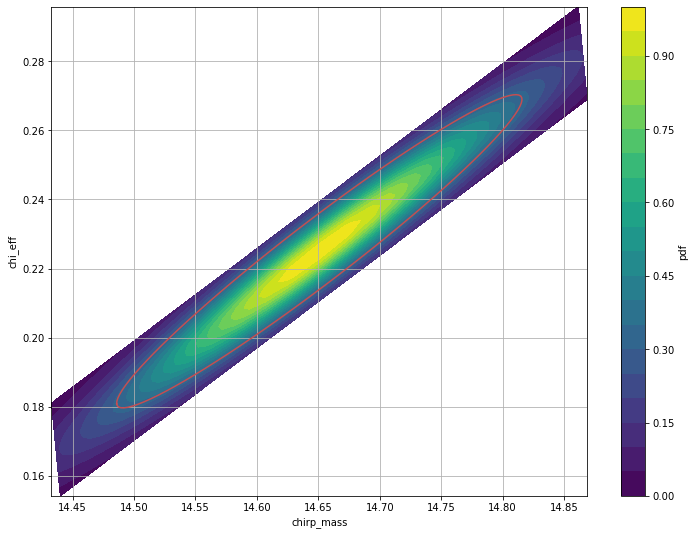

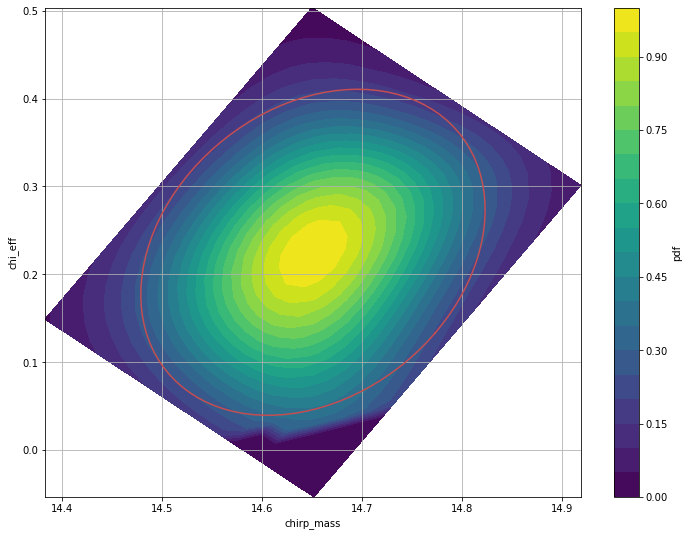

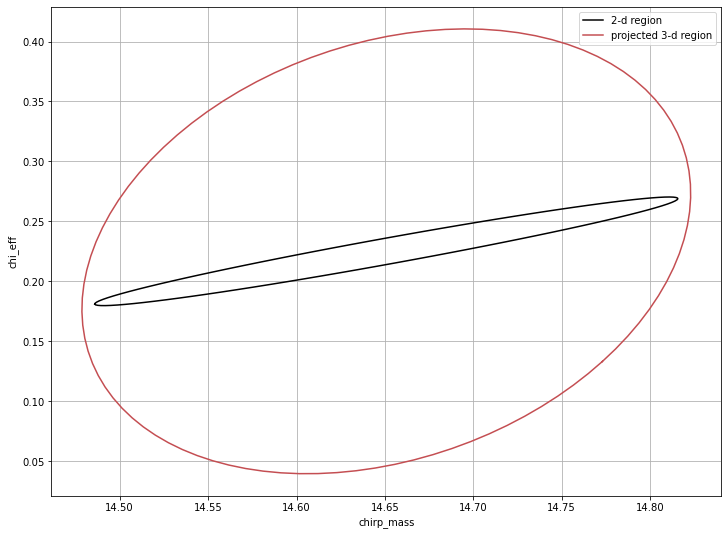

In [36]:
for key, dx_keep in keep_dirs.items():
    proj_dir = [x for x in dx_directions if x not in keep_dirs[key] ][0]
    
    # generate 2d regions
    ellipse = g_2d[key].generate_ellipse()
    matches = g_2d[key].generate_match_grid(npts=npts, mismatch=g_2d[key].mismatch*(1.3)**2)
    prob = np.exp(-snr**2/2 * (1 - matches['match']))
    
    # plot them
    plt.figure(figsize=(12, 9))
    plt.contourf(matches.samples[0], matches.samples[1], prob, levels=np.linspace(0, 1, 21))
    plt.xlabel(matches.keys()[0])
    plt.ylabel(matches.keys()[1])
    plt.colorbar(label='pdf')
    plt.plot(ellipse.samples[0], ellipse.samples[1], 'r')
    plt.grid()
    if savefig:
        plt.savefig('figures/ellipse_%s_2d.png' % key)
    
    # generate 3d regions
    g_3d.project_metric(dx_keep)
    three_d_ellipse = g_3d.generate_ellipse(projected=True)
    proj_matches = g_3d.generate_match_grid(projected=True, mismatch = g_3d.mismatch * (1.1)**2, npts=npts)
    proj_prob = np.exp(-snr**2/2 * (1 - proj_matches['match']))
    
    # and plot
    plt.figure(figsize=(12, 9))
    plt.contourf(proj_matches.samples[0].reshape([npts,npts]), proj_matches.samples[1].reshape([npts,npts]), 
                 proj_prob.reshape([npts,npts]), levels=np.linspace(0, 1, npts))
    plt.xlabel(proj_matches.keys()[0])
    plt.ylabel(proj_matches.keys()[1])
    plt.colorbar(label='pdf')
    plt.plot(three_d_ellipse.samples[0], three_d_ellipse.samples[1], 'r')
    plt.grid()
    if savefig:
        plt.savefig('figures/ellipse_%s_project_%s.png' % (key, proj_dir))

    # compare 2-d and projected region
    plt.figure(figsize=(12, 9))
    plt.plot(ellipse.samples[0], ellipse.samples[1], 'k', label='2-d region')
    plt.plot(three_d_ellipse.samples[0], three_d_ellipse.samples[1], 'r', label='projected 3-d region')
    plt.xlabel(three_d_ellipse.keys()[0])
    plt.ylabel(three_d_ellipse.keys()[1])
    plt.grid()
    plt.legend()
    if savefig:
        plt.savefig('figures/ellipse_compare_%s_project_%s.png' % (key, proj_dir))

In [41]:
samps = g_3d.generate_samples()

In [43]:
import corner

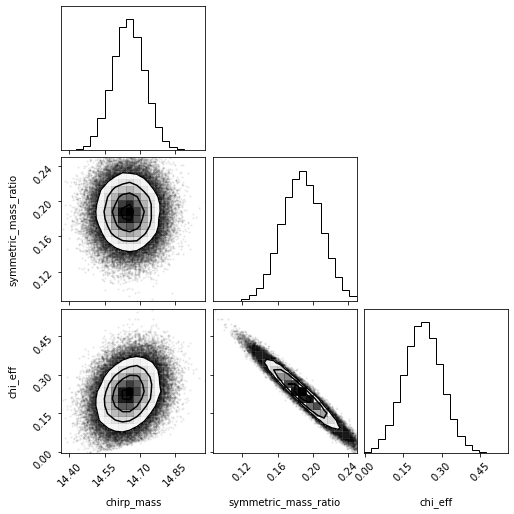

In [44]:
corner.corner(samps)
plt.savefig('figures/3d_metric_corner.png')